In [14]:
FILE = '../data/penguin/penguins_final_with_era5.csv'

### Adelie penguin

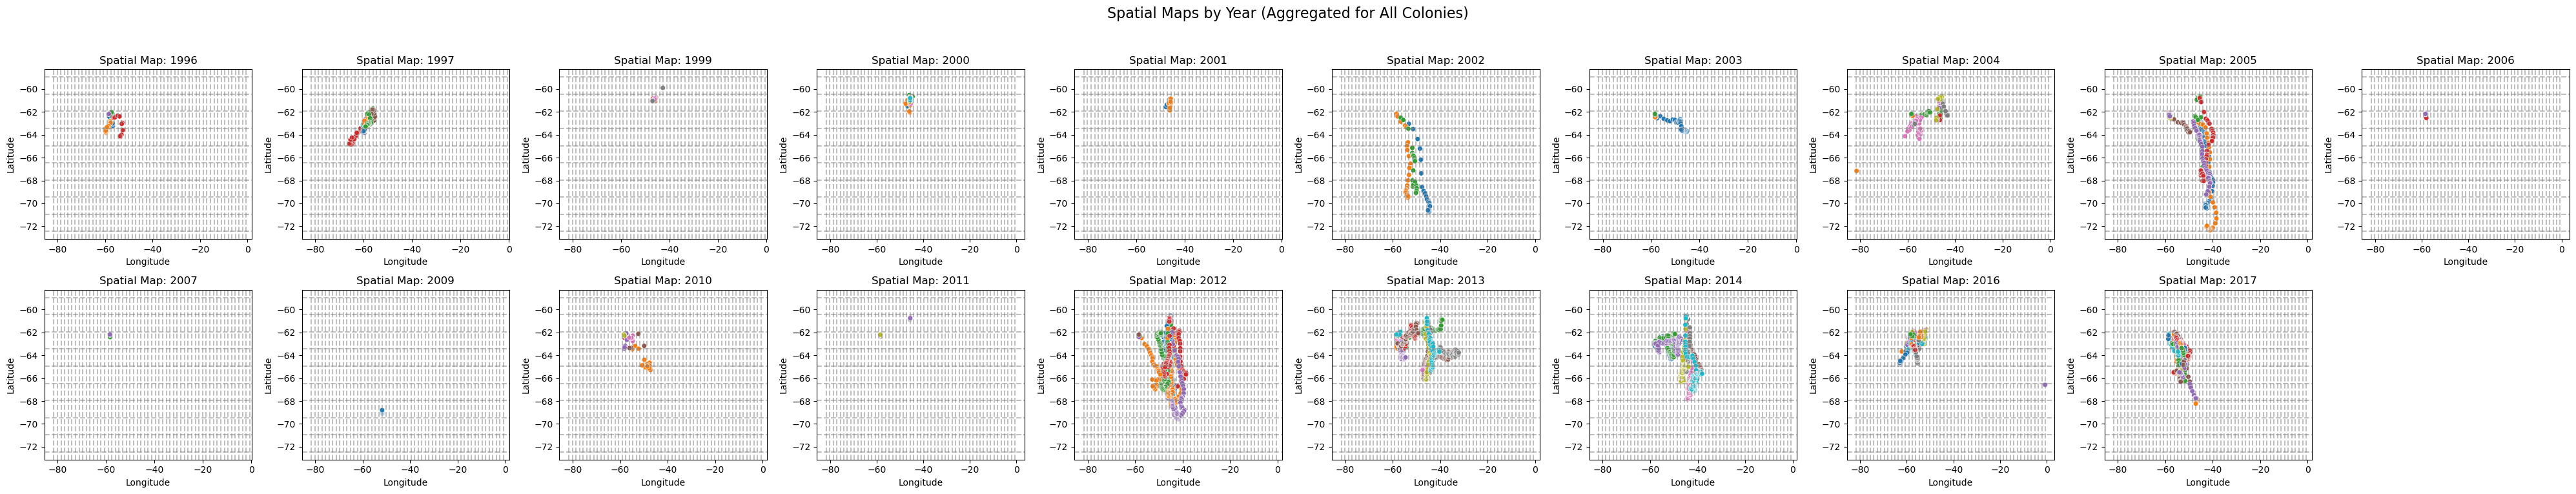

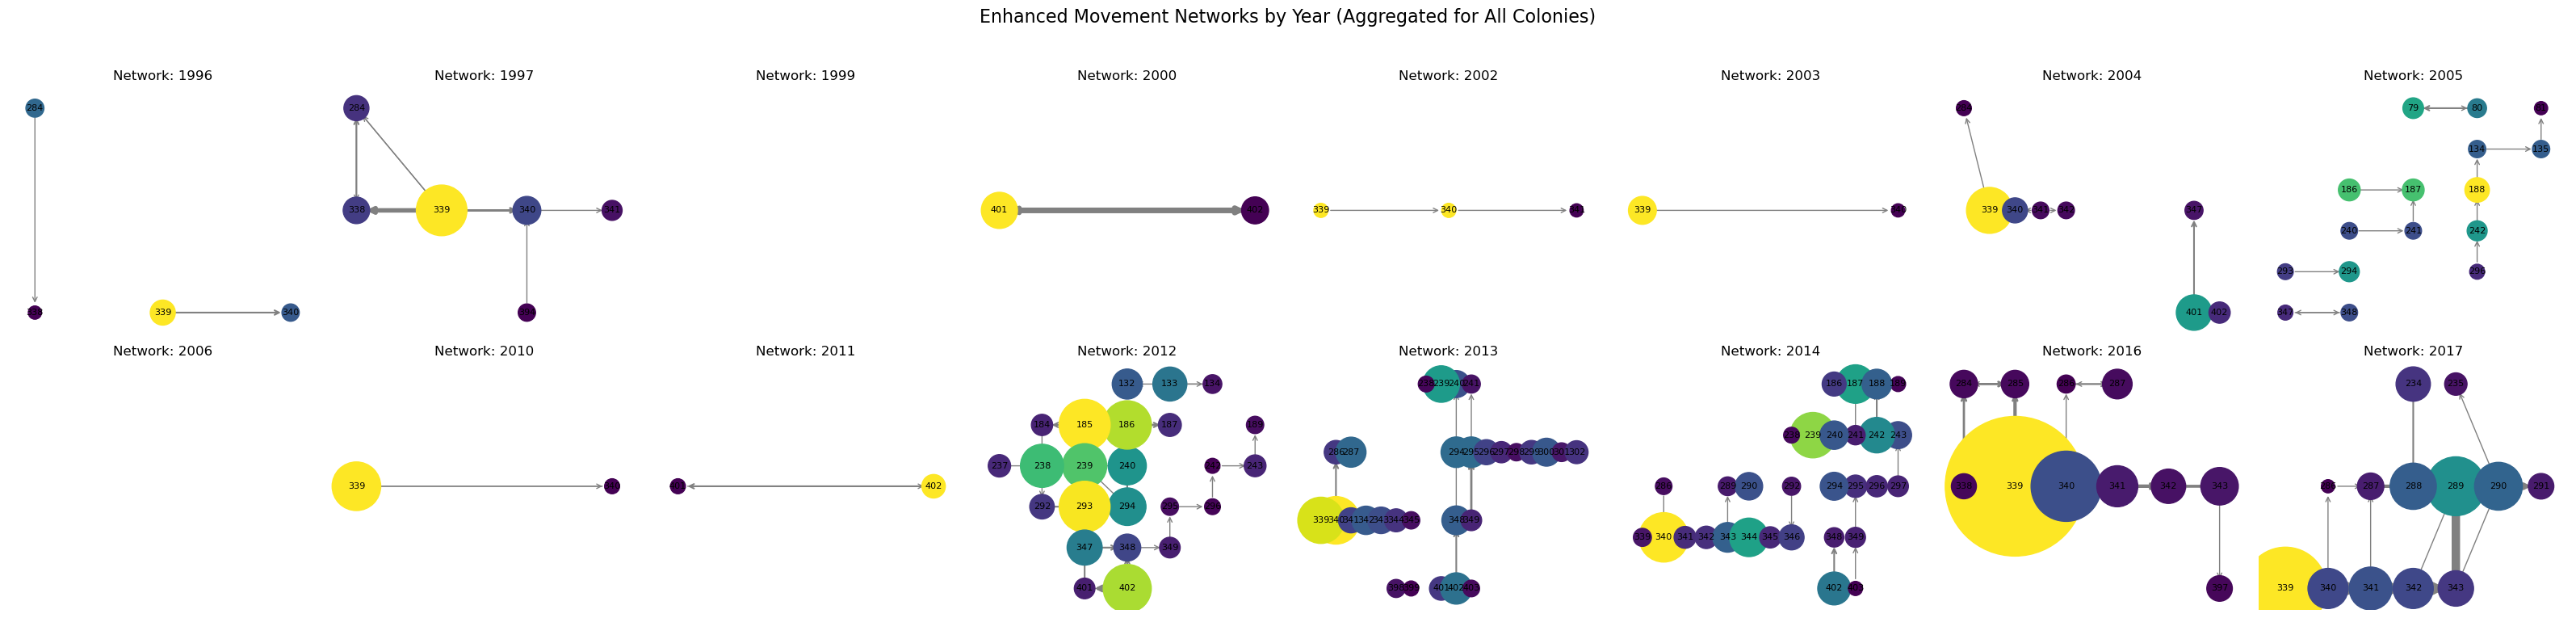

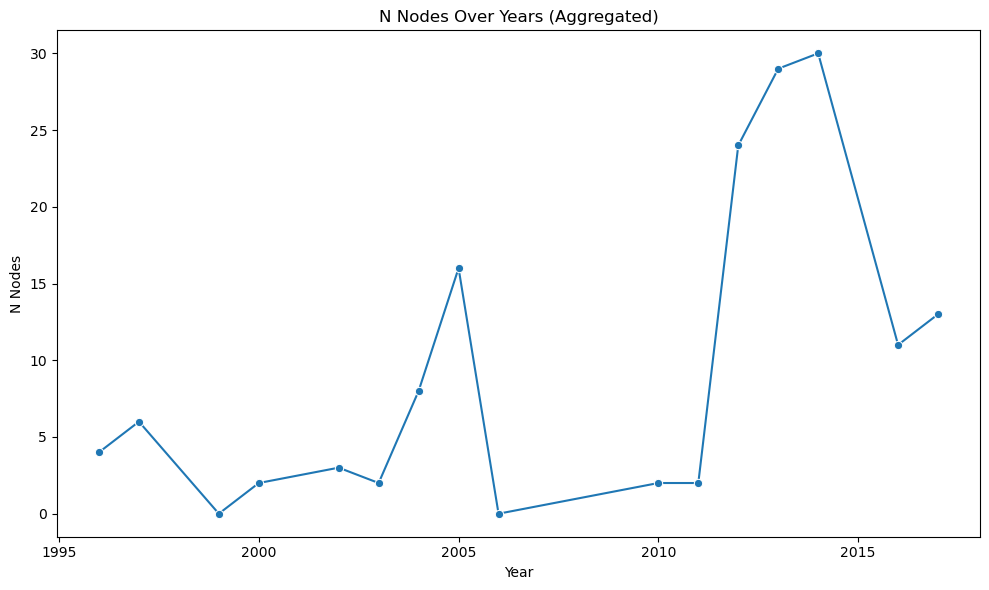

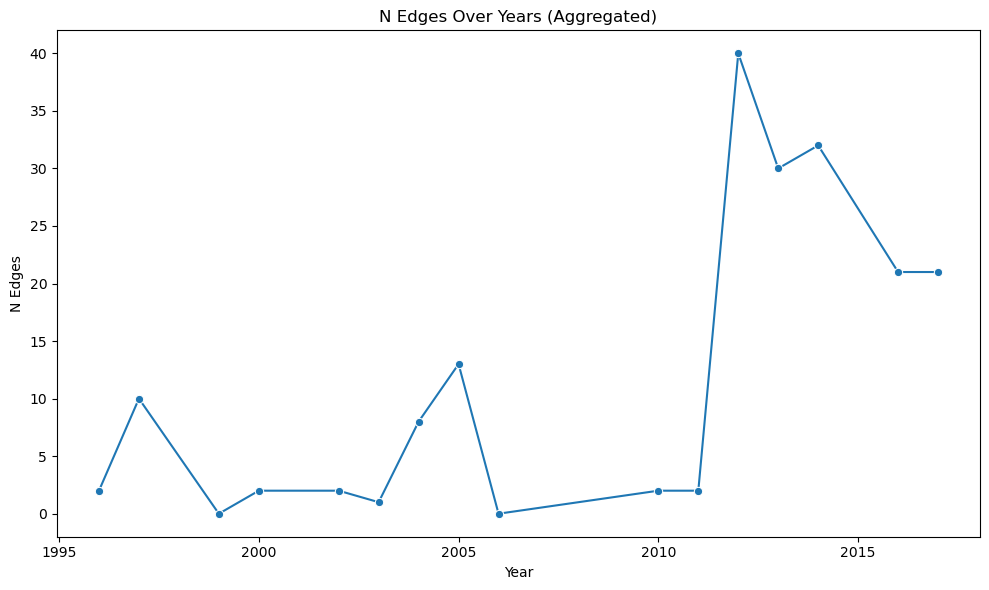

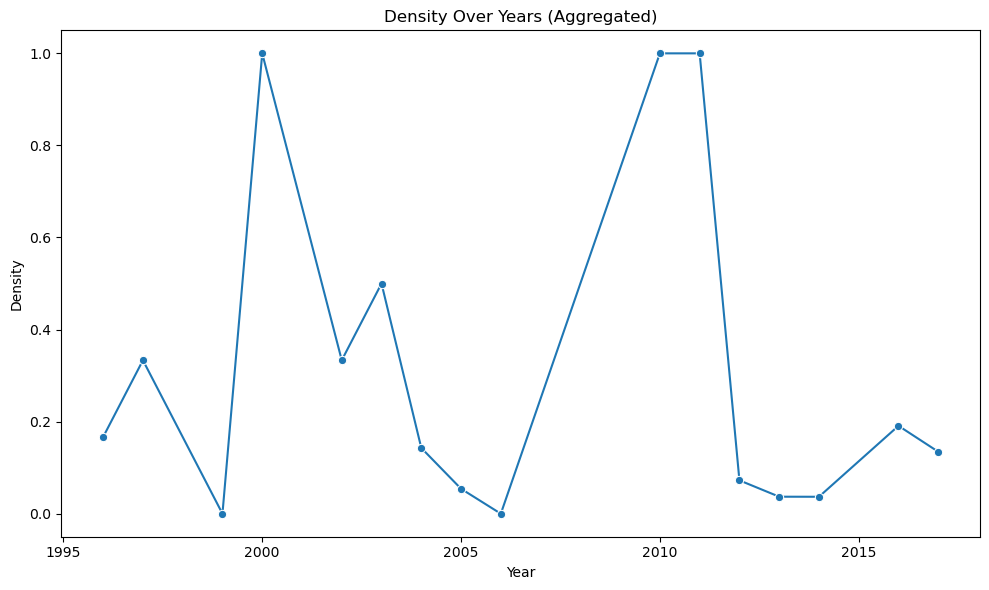

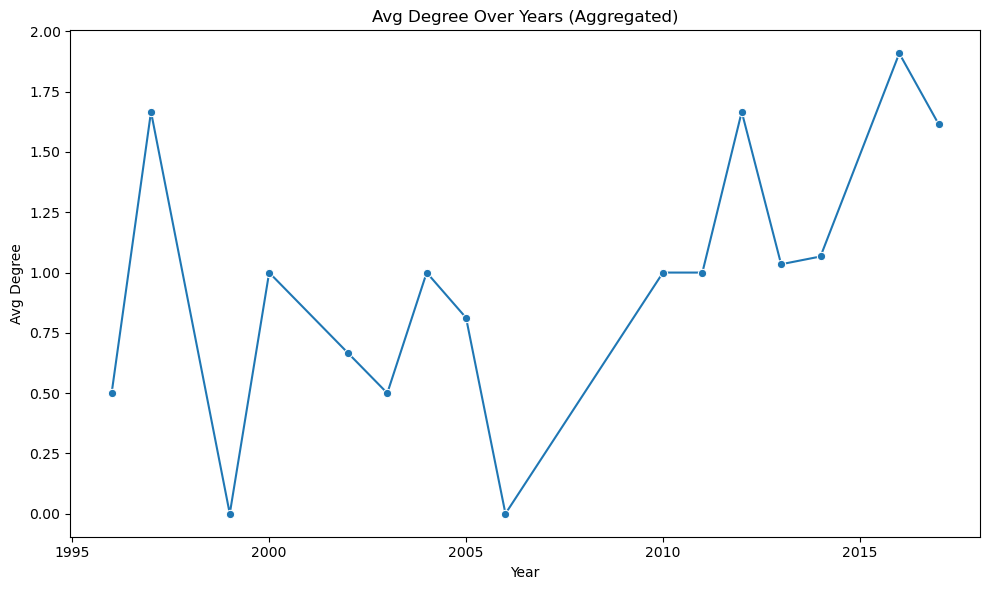

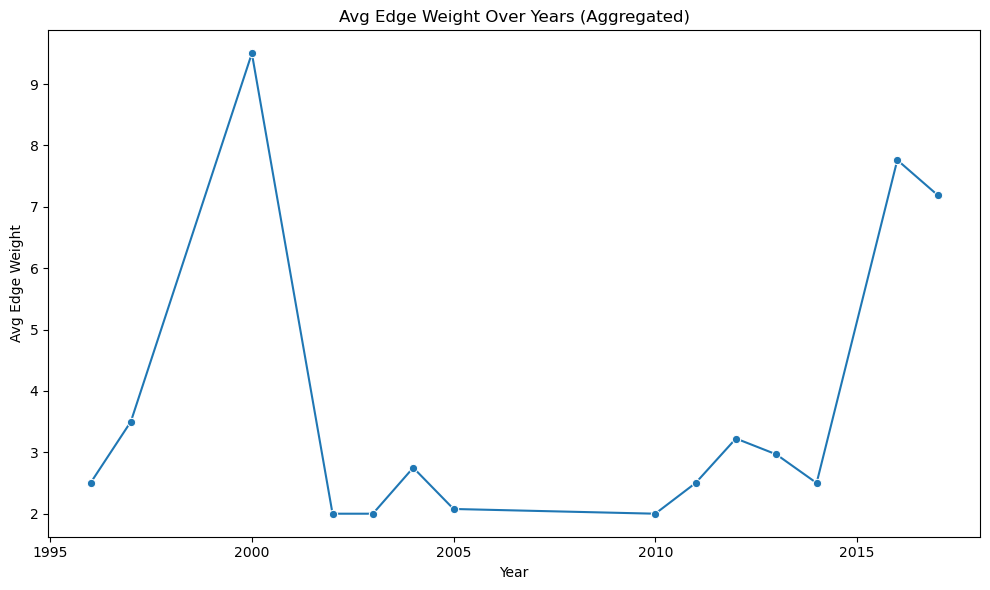

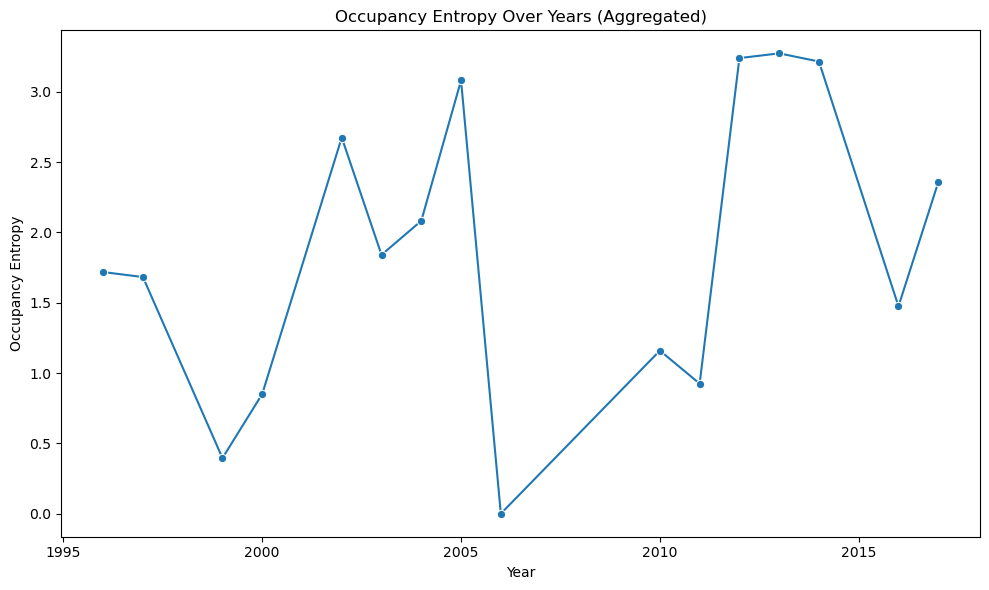

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_10867/2675726809.py:407: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')


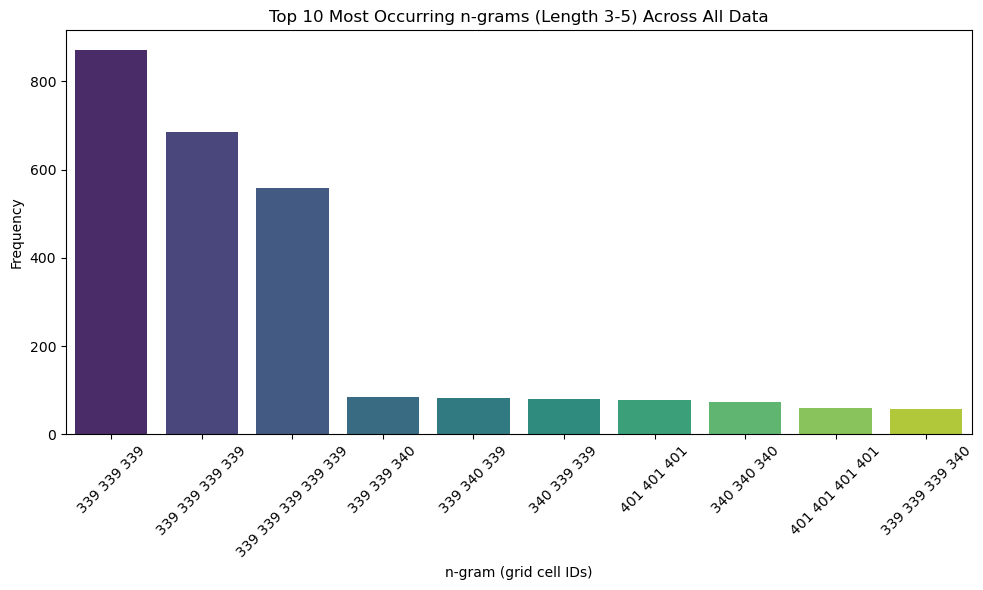

In [87]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Aggregated Spatial and Network Analysis for Adelie Penguin (Whole Species)

This script performs the following steps:
  1. Filters the dataset for species "Adelie Penguin" and rasterizes all locations
     onto a fixed grid with cell size 1.75°×1.75°.
  2. For each year (aggregating across all colonies), it produces:
       - A spatial map showing raw latitude–longitude points with grid boundaries overlaid.
       - An enhanced network graph where nodes are placed at the geographic centers of the grid cells;
         node sizes and colors reflect visit frequency (darker colors mean higher occupancy), and edge widths
         are proportional to the number of transitions (only edges with weight ≥ MIN_EDGE_WEIGHT are retained).
  3. It then plots time‐series (line plots with markers) of aggregated network metrics over the years.
  4. Finally, it extracts all contiguous n-grams (motifs) of length 3–5 from the grid cell sequences and
     plots a bar graph of the top 10 most frequent n-grams.
  
In the spatial maps the grid lines indicate the boundaries of each 1.75°×1.75° cell. In the network graphs,
node colors (using the viridis colormap) indicate occupancy—darker colors represent higher visit frequency.

Required packages: pandas, numpy, networkx, matplotlib, scipy, seaborn
"""

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
from collections import Counter

# ========================================
# Global Variables
# ========================================
FILE = "../data/penguin/penguins_final_with_era5.csv"
SPECIES = "Adelie Penguin"         # Exact species name.
FIXED_RESOLUTION = 1.5            # Grid cell size in degrees.
MIN_EDGE_WEIGHT = 2                # Only retain edges with weight ≥ 2.
MIN_YEAR_POINTS = 20               # Minimum records per year to process.

# ========================================
# HELPER FUNCTIONS
# ========================================

def compute_step_lengths(df, lat_col='latitude_mean', lon_col='longitude_mean'):
    """Compute Euclidean step lengths between consecutive points (first step = 0)."""
    coords = df[[lat_col, lon_col]].values
    diff = np.diff(coords, axis=0)
    steps = np.sqrt((diff ** 2).sum(axis=1))
    steps = np.insert(steps, 0, 0)
    df = df.copy()
    df['step_length'] = steps
    return df

def assign_grid_cells(df, lat_col='latitude_mean', lon_col='longitude_mean', resolution=FIXED_RESOLUTION):
    """
    Rasterize coordinates onto a fixed grid with cell size = resolution.
    A 0.1° buffer is added to ensure full coverage.
    Each cell is assigned an ID based on its row and column.
    Returns the modified DataFrame (with 'cell_id') and grid_info dictionary.
    """
    buffer_val = 0.1
    min_lat = df[lat_col].min() - buffer_val
    max_lat = df[lat_col].max() + buffer_val
    min_lon = df[lon_col].min() - buffer_val
    max_lon = df[lon_col].max() + buffer_val
    n_rows = int(np.ceil((max_lat - min_lat) / resolution))
    n_cols = int(np.ceil((max_lon - min_lon) / resolution))
    df = df.copy()
    df['row'] = ((df[lat_col] - min_lat) / resolution).astype(int)
    df['col'] = ((df[lon_col] - min_lon) / resolution).astype(int)
    df['cell_id'] = df['row'] * n_cols + df['col']
    grid_info = {
        'resolution': resolution,
        'min_lat': min_lat, 'max_lat': max_lat,
        'min_lon': min_lon, 'max_lon': max_lon,
        'n_rows': n_rows, 'n_cols': n_cols
    }
    return df, grid_info

def get_node_center(cell_id, grid_info):
    """
    Compute the geographic center (longitude, latitude) for a grid cell with given cell_id.
    Row 0 is assumed to be at the top (highest latitude).
    """
    n_cols = grid_info['n_cols']
    row = cell_id // n_cols
    col = cell_id % n_cols
    center_lon = grid_info['min_lon'] + (col + 0.5) * grid_info['resolution']
    center_lat = grid_info['max_lat'] - (row + 0.5) * grid_info['resolution']
    return center_lon, center_lat

def build_year_network(df_year, min_edge_weight=MIN_EDGE_WEIGHT):
    """
    Build a weighted directed network for a given year's data.
    For each track (grouped by 'track_id'), count transitions (ignoring self-transitions),
    aggregate counts, and keep only edges with weight >= min_edge_weight.
    Returns a weighted DiGraph.
    """
    edge_counter = Counter()
    for track, group in df_year.groupby('track_id'):
        group = group.sort_values(by='date_gmt')
        cell_seq = group['cell_id'].tolist()
        for i in range(len(cell_seq) - 1):
            if cell_seq[i] != cell_seq[i+1]:
                edge_counter[(cell_seq[i], cell_seq[i+1])] += 1
    filtered_edges = {edge: w for edge, w in edge_counter.items() if w >= min_edge_weight}
    G = nx.DiGraph()
    for (u, v), w in filtered_edges.items():
        G.add_edge(u, v, weight=w)
    return G

def compute_network_metrics(G):
    """
    Compute basic network metrics for a weighted DiGraph G.
    Returns a dictionary with:
      - n_nodes, n_edges, density, avg_degree, and avg_edge_weight.
    """
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G) if n_nodes > 1 else 0
    avg_degree = n_edges / n_nodes if n_nodes > 0 else 0
    if n_edges > 0:
        avg_edge_weight = np.mean([d.get('weight', 1) for u, v, d in G.edges(data=True)])
    else:
        avg_edge_weight = np.nan
    return {'n_nodes': n_nodes, 'n_edges': n_edges, 'density': density,
            'avg_degree': avg_degree, 'avg_edge_weight': avg_edge_weight}

def compute_occupancy_entropy(df, cell_col='cell_id'):
    """
    Compute the Shannon entropy of the occupancy distribution (visit frequencies) across grid cells.
    """
    counts = Counter(df[cell_col])
    freqs = np.array(list(counts.values()))
    probabilities = freqs / freqs.sum()
    return entropy(probabilities)

def plot_network_enhanced(G, grid_info, df, ax, title="Enhanced Movement Network"):
    """
    Plot an enhanced network visualization on the given Axes.
    Nodes are placed at the geographic centers of their grid cells;
    node sizes and colors reflect visit frequency; edge widths scale with transition weight.
    """
    occ_counts = Counter(df['cell_id'])
    pos = {}
    node_sizes = []
    node_colors = []
    n_cols = grid_info['n_cols']
    for node in G.nodes():
        center = get_node_center(node, grid_info)
        pos[node] = center
        freq = occ_counts.get(node, 0)
        node_sizes.append(100 + freq * 20)
        node_colors.append(freq)
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis,
                                   node_size=node_sizes, ax=ax)
    weights = [d.get('weight', 1) for u, v, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights],
                           arrowstyle='->', arrowsize=10, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    ax.set_title(title)
    ax.axis('off')

def plot_spatial_map_with_grid(df, grid_info, ax, title="Spatial Map with Grid"):
    """
    Plot a spatial map of raw latitude–longitude points on the given Axes,
    with grid boundaries overlaid.
    """
    sns.scatterplot(data=df, x='longitude_mean', y='latitude_mean', hue='track_id',
                    palette='tab10', legend=False, s=30, ax=ax)
    res = grid_info['resolution']
    min_lon = grid_info['min_lon']
    max_lon = grid_info['max_lon']
    min_lat = grid_info['min_lat']
    max_lat = grid_info['max_lat']
    lon_lines = np.arange(min_lon, max_lon+res, res)
    lat_lines = np.arange(min_lat, max_lat+res, res)
    for lon in lon_lines:
        ax.axvline(x=lon, color='gray', linestyle='--', alpha=0.5)
    for lat in lat_lines:
        ax.axhline(y=lat, color='gray', linestyle='--', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

def extract_ngrams(sequence, min_length=3, max_length=5):
    """
    Extract all contiguous n-grams (subsequences) from a sequence
    with lengths between min_length and max_length.
    Returns a list of n-grams (each is a list of grid cell IDs).
    """
    ngrams = []
    L = len(sequence)
    for n in range(min_length, max_length+1):
        for i in range(L - n + 1):
            ngram = sequence[i:i+n]
            ngrams.append(ngram)
    return ngrams

def compute_shannon_index(codes):
    """Compute the Shannon diversity index from a list of pattern strings."""
    counts = Counter(codes)
    freqs = np.array(list(counts.values()))
    probabilities = freqs / freqs.sum()
    return entropy(probabilities)

# ========================================
# MAIN ANALYSIS: Aggregated Visualizations for the Whole Species
# ========================================

def main():
    # Read data and convert dates.
    df = pd.read_csv(FILE)
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    
    # --- Step 1: Filter Data for Species "Adelie Penguin" ---
    df_species = df[df['common_name'] == SPECIES].copy()
    if df_species.empty:
        print(f"No data found for species {SPECIES}.")
        return
    
    # Rasterize all species data.
    df_species, grid_info = assign_grid_cells(df_species, resolution=FIXED_RESOLUTION)
    df_species['year'] = df_species['date_gmt'].dt.year
    
    # --- Step 2: Plot Spatial Maps by Year (Aggregated for All Colonies) ---
    plot_spatial_map_with_grid(df_species, grid_info, ax=plt.gca(), title="(Temporary) Spatial Map")
    # For separate subplots, use the dedicated function.
    plot_spatial_map_by_year(df_species, grid_info)
    
    # --- Step 3: Plot Enhanced Network Graphs by Year (Aggregated for All Colonies) ---
    plot_networks_by_year(df_species, grid_info)
    
    # --- Step 4: Plot Aggregated Network Metrics Over Time ---
    plot_network_metrics_over_time(df_species)
    
    # --- Step 5: Motif Extraction Using n-grams (Length 3-5) ---
    df_species = df_species.sort_values(by='date_gmt')
    cell_seq_all = df_species['cell_id'].tolist()
    ngrams_all = extract_ngrams(cell_seq_all, min_length=3, max_length=5)
    if ngrams_all:
        # For a more interpretable motif, you might recode the n-gram into letters.
        # Here, for simplicity, we join the grid cell IDs as a string.
        motif_patterns = [" ".join(map(str, ngram)) for ngram in ngrams_all]
        motif_counts = Counter(motif_patterns)
        top_motifs = motif_counts.most_common(10)
        patterns, freqs = zip(*top_motifs)
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')
        plt.title("Top 10 Most Occurring n-grams (Length 3-5) Across All Data")
        plt.xlabel("n-gram (grid cell IDs)")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No n-grams extracted.")

    
# The following two functions (plot_spatial_map_by_year and plot_networks_by_year) and plot_network_metrics_over_time 
# are defined below so that they can be called in main().

def plot_spatial_map_by_year(df_species, grid_info):
    """
    For each year, plot a subplot showing the spatial distribution (raw latitude–longitude points)
    with the grid boundaries overlaid.
    """
    years = sorted(df_species['year'].unique())
    n_years = len(years)
    if n_years <= 6:
        n_rows, n_cols = 1, n_years
    else:
        n_rows = 2
        n_cols = int(np.ceil(n_years / 2))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).flatten()
    for idx, yr in enumerate(years):
        df_year = df_species[df_species['year'] == yr].copy()
        ax = axes[idx]
        sns.scatterplot(data=df_year, x='longitude_mean', y='latitude_mean', hue='track_id',
                        palette='tab10', legend=False, s=30, ax=ax)
        res = grid_info['resolution']
        min_lon = grid_info['min_lon']
        max_lon = grid_info['max_lon']
        min_lat = grid_info['min_lat']
        max_lat = grid_info['max_lat']
        lon_lines = np.arange(min_lon, max_lon+res, res)
        lat_lines = np.arange(min_lat, max_lat+res, res)
        for lon in lon_lines:
            ax.axvline(x=lon, color='gray', linestyle='--', alpha=0.5)
        for lat in lat_lines:
            ax.axhline(y=lat, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f"Spatial Map: {yr}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Spatial Maps by Year (Aggregated for All Colonies)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_networks_by_year(df_species, grid_info):
    """
    For each year, build a weighted network (aggregated for all colonies) and plot a subplot showing the enhanced network graph.
    """
    years = sorted(df_species['year'].unique())
    valid_years = [yr for yr in years if len(df_species[df_species['year']==yr])>=MIN_YEAR_POINTS]
    n_years = len(valid_years)
    if n_years <= 6:
        n_rows, n_cols = 1, n_years
    else:
        n_rows = 2
        n_cols = int(np.ceil(n_years / 2))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    axes = np.array(axes).flatten()
    for idx, yr in enumerate(valid_years):
        df_year = df_species[df_species['year'] == yr].copy()
        df_year = df_year.sort_values(by='date_gmt')
        G_year = build_year_network(df_year, min_edge_weight=MIN_EDGE_WEIGHT)
        ax = axes[idx]
        plot_network_enhanced(G_year, grid_info, df_year, ax, title=f"Network: {yr}")
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle("Enhanced Movement Networks by Year (Aggregated for All Colonies)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_network_metrics_over_time(df_species):
    """
    For each year, build a weighted network (aggregated for all colonies) and compute network metrics.
    Then, plot the development of these metrics over time.
    """
    years = sorted(df_species['year'].unique())
    metrics_list = []
    for yr in years:
        df_year = df_species[df_species['year'] == yr].copy()
        if len(df_year) < MIN_YEAR_POINTS:
            continue
        df_year = df_year.sort_values(by='date_gmt')
        G_year = build_year_network(df_year, min_edge_weight=MIN_EDGE_WEIGHT)
        metrics = compute_network_metrics(G_year)
        occ_entropy = compute_occupancy_entropy(df_year)
        metrics.update({'year': yr, 'n_obs': len(df_year), 'n_tracks': df_year['track_id'].nunique(),
                        'occupancy_entropy': occ_entropy})
        metrics_list.append(metrics)
    if metrics_list:
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df = metrics_df.sort_values(by='year')
        metric_names = ['n_nodes', 'n_edges', 'density', 'avg_degree', 'avg_edge_weight', 'occupancy_entropy']
        for m in metric_names:
            plt.figure(figsize=(10,6))
            sns.lineplot(data=metrics_df, x='year', y=m, marker='o')
            plt.title(f"{m.replace('_',' ').title()} Over Years (Aggregated)")
            plt.xlabel("Year")
            plt.ylabel(m.replace('_',' ').title())
            plt.tight_layout()
            plt.show()
    else:
        print("No network metrics available over time.")

def compute_shannon_index(codes):
    """Compute the Shannon diversity index from a list of pattern strings."""
    counts = Counter(codes)
    freqs = np.array(list(counts.values()))
    probabilities = freqs / freqs.sum()
    return entropy(probabilities)

# ========================================
# MAIN
# ========================================

def main():
    df = pd.read_csv(FILE)
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    
    # Filter for species "Adelie Penguin".
    df_species = df[df['common_name'] == SPECIES].copy()
    if df_species.empty:
        print(f"No data found for species {SPECIES}.")
        return
    
    # Rasterize all data.
    df_species, grid_info = assign_grid_cells(df_species, resolution=FIXED_RESOLUTION)
    df_species['year'] = df_species['date_gmt'].dt.year
    
    # Plot spatial maps by year.
    plot_spatial_map_by_year(df_species, grid_info)
    
    # Plot enhanced network graphs by year.
    plot_networks_by_year(df_species, grid_info)
    
    # Plot aggregated network metrics over time.
    plot_network_metrics_over_time(df_species)
    
    # --- Motif Extraction using n-grams ---
    df_species = df_species.sort_values(by='date_gmt')
    cell_seq_all = df_species['cell_id'].tolist()
    ngrams_all = extract_ngrams(cell_seq_all, min_length=3, max_length=5)
    if ngrams_all:
        # For interpretability, recode each n-gram as a space-separated string.
        motif_patterns = [" ".join(map(str, ngram)) for ngram in ngrams_all]
        motif_counts = Counter(motif_patterns)
        top_motifs = motif_counts.most_common(10)
        patterns, freqs = zip(*top_motifs)
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')
        plt.title("Top 10 Most Occurring n-grams (Length 3-5) Across All Data")
        plt.xlabel("n-gram (grid cell IDs)")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No n-grams extracted.")

    
if __name__ == '__main__':
    main()


## Chinstrap Penguin

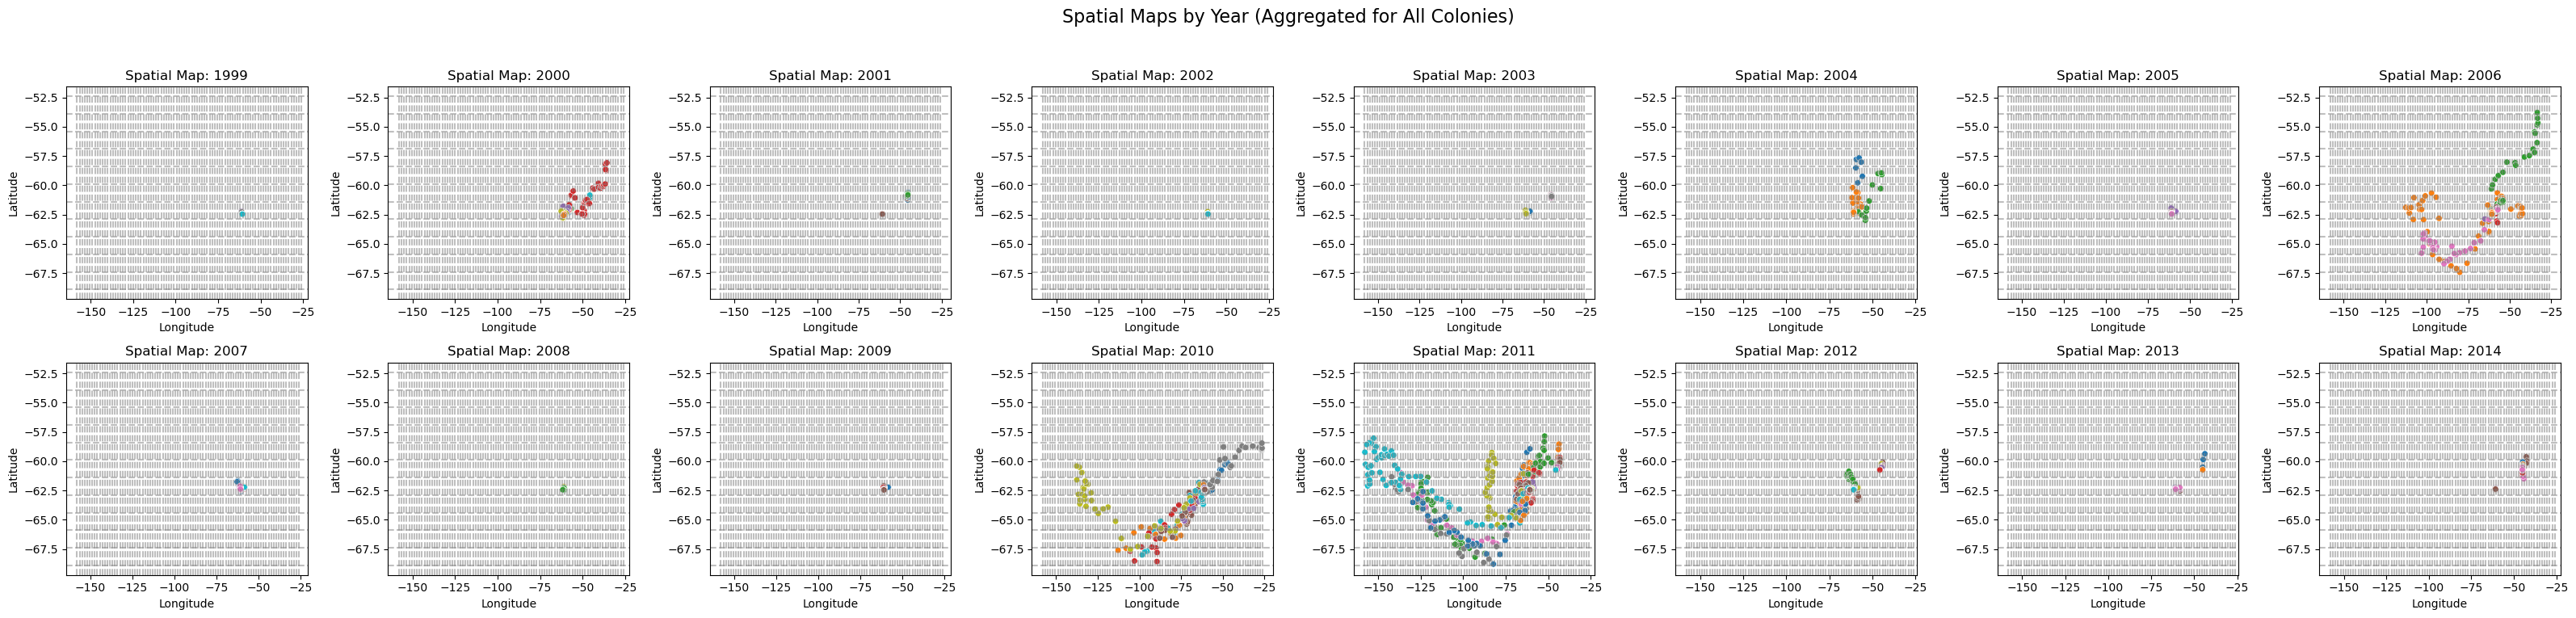

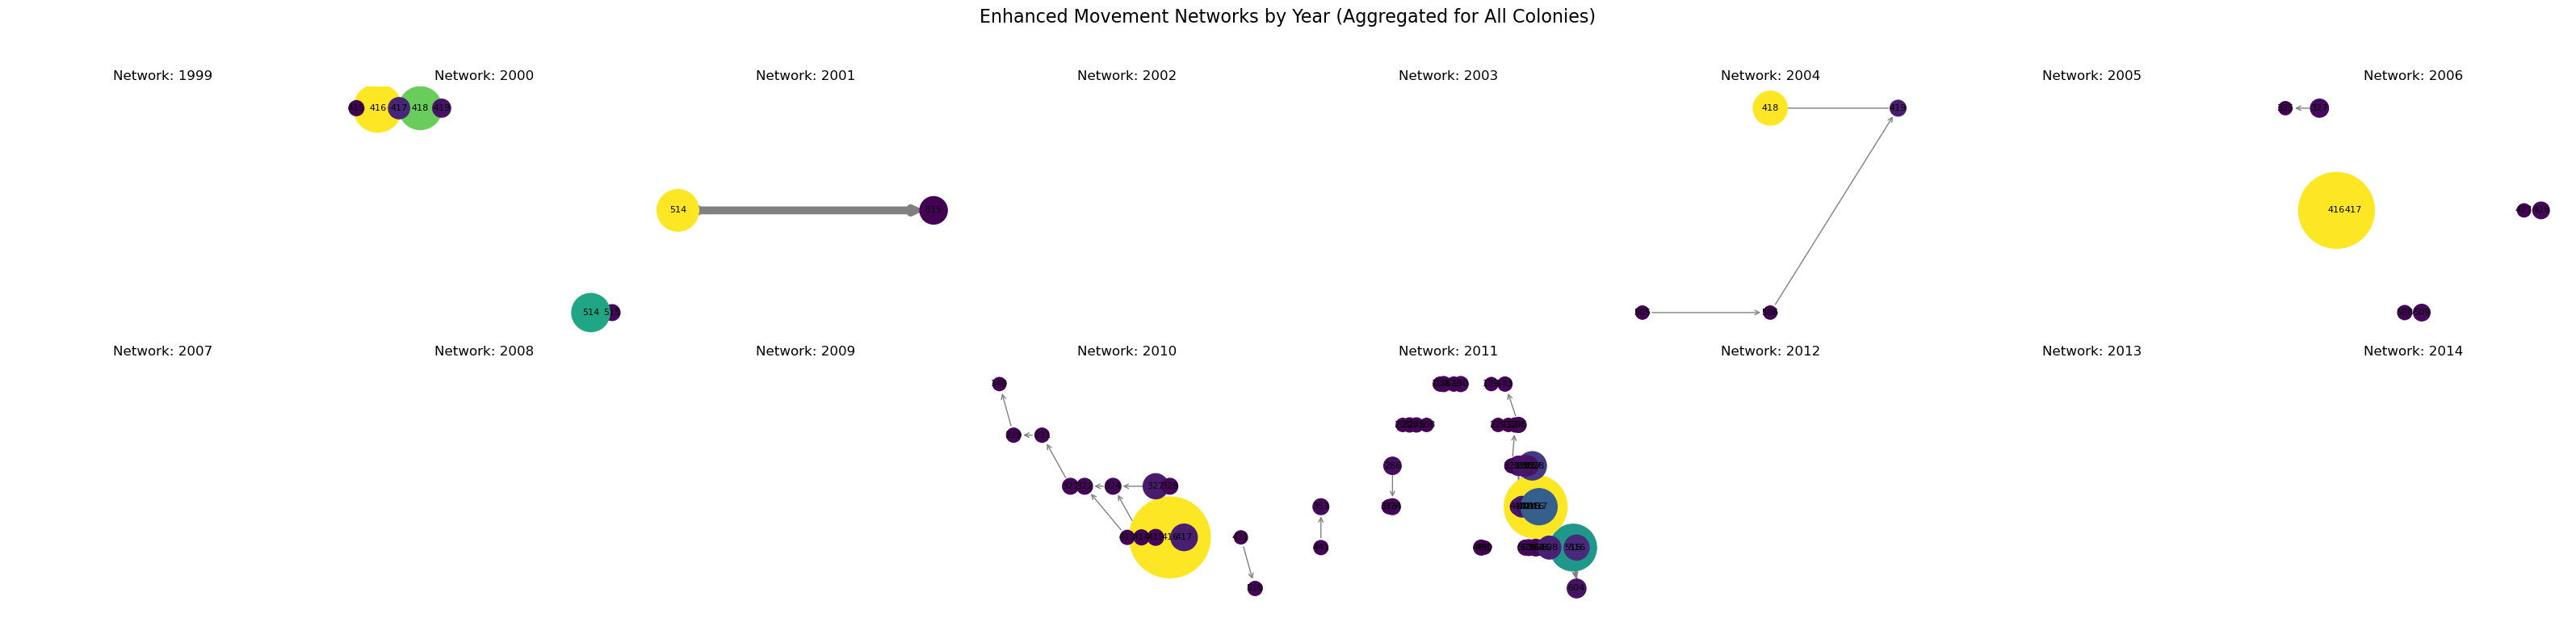

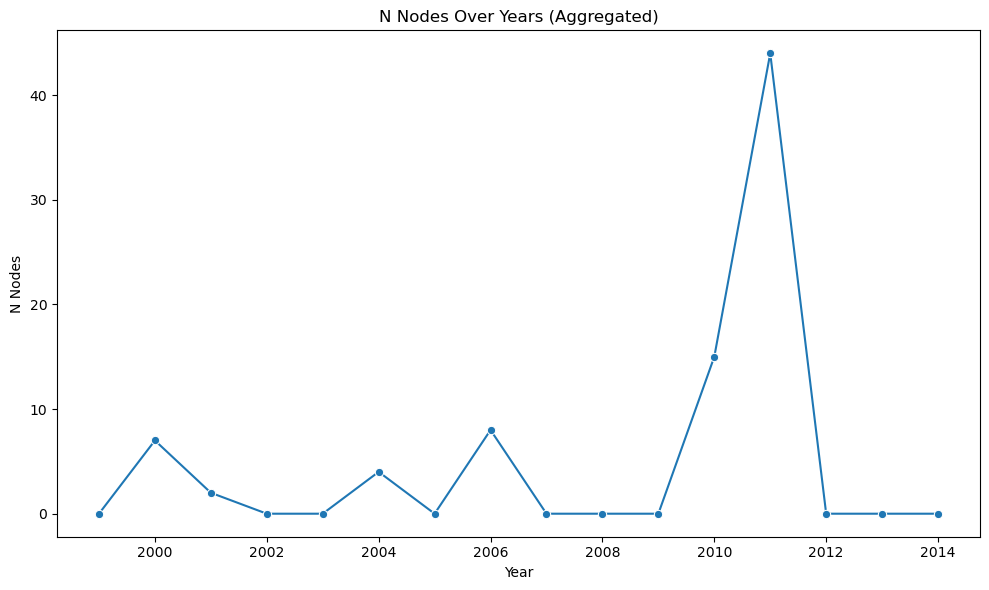

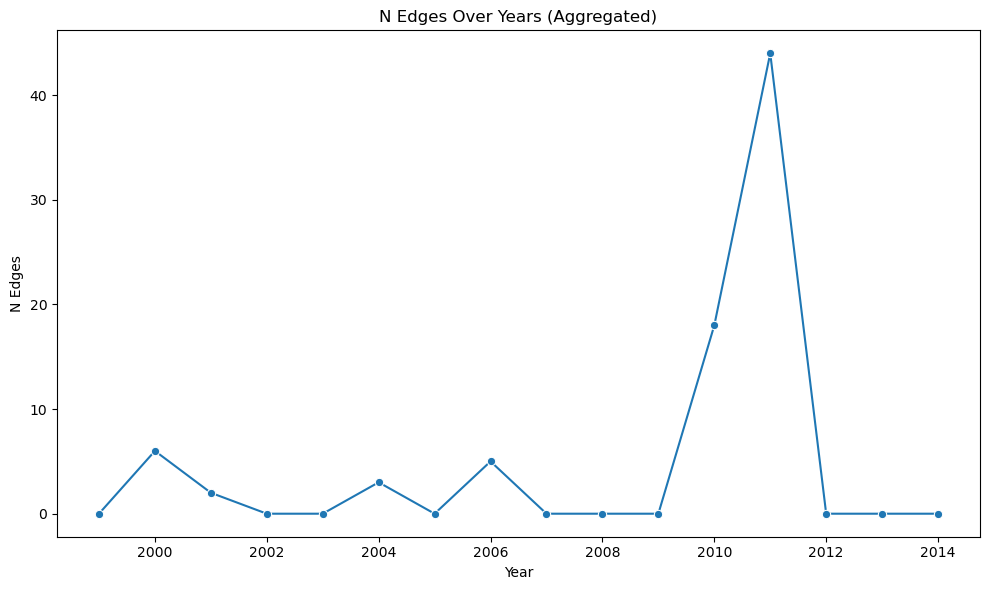

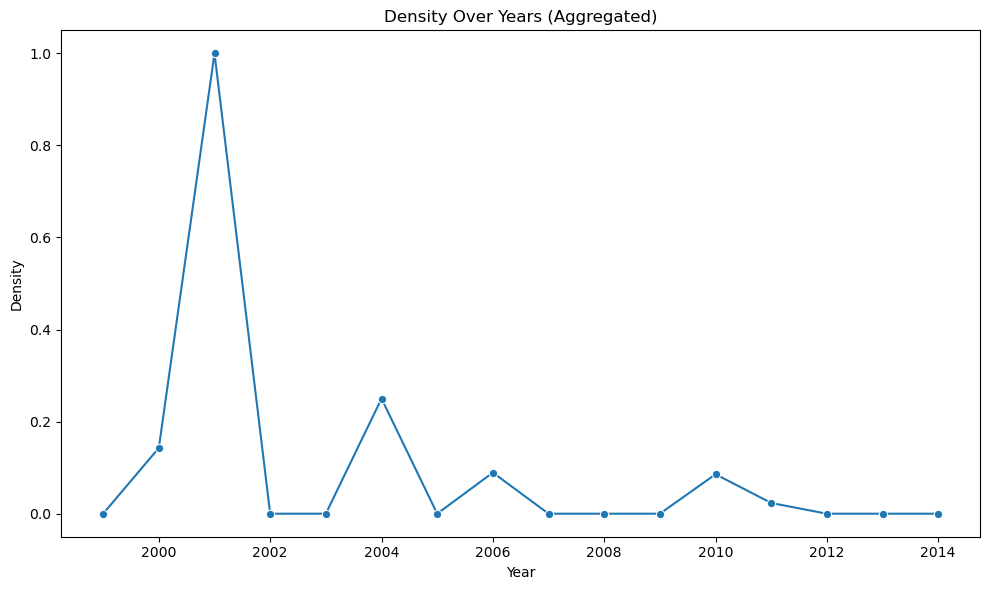

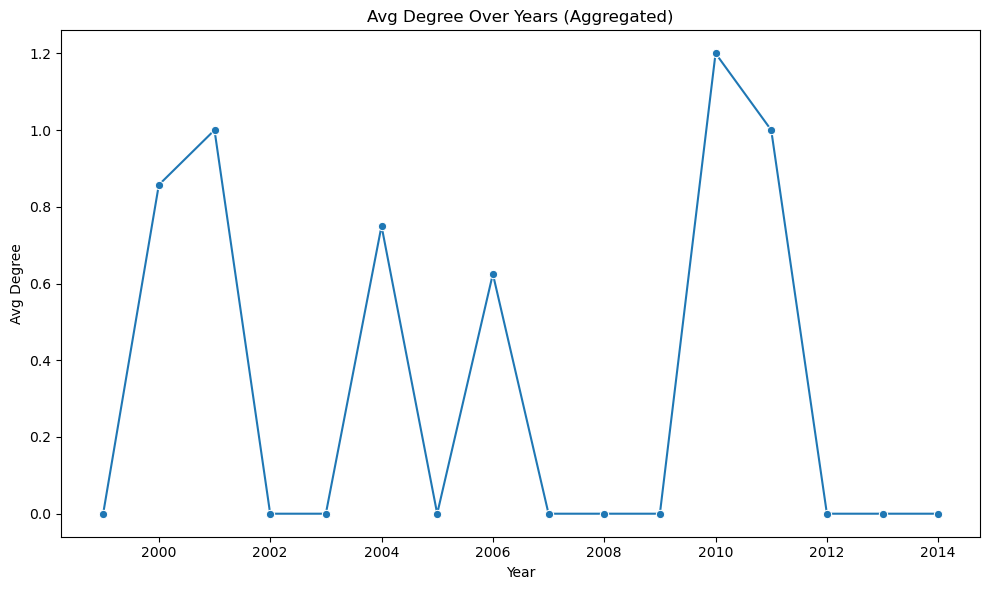

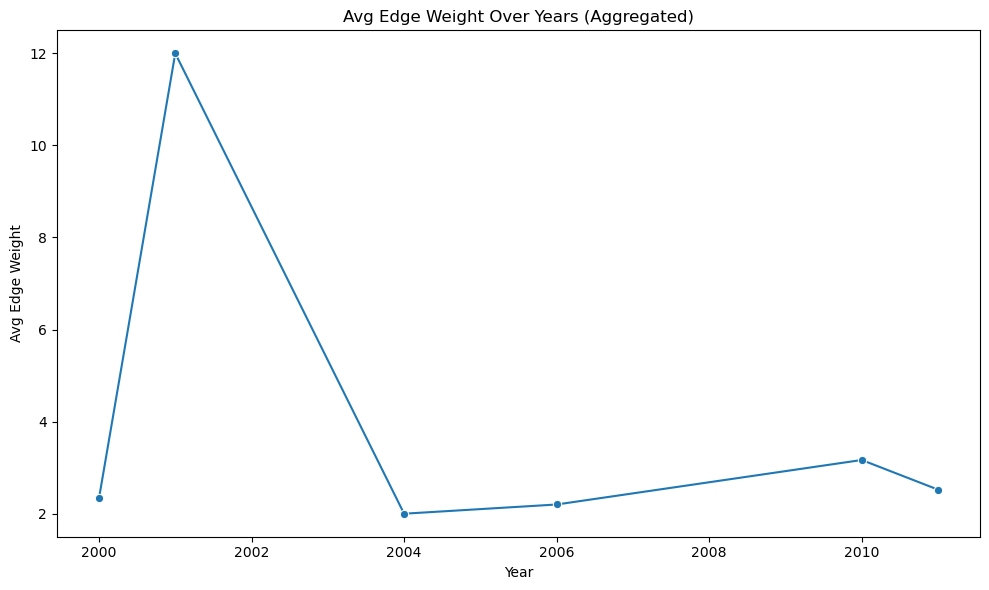

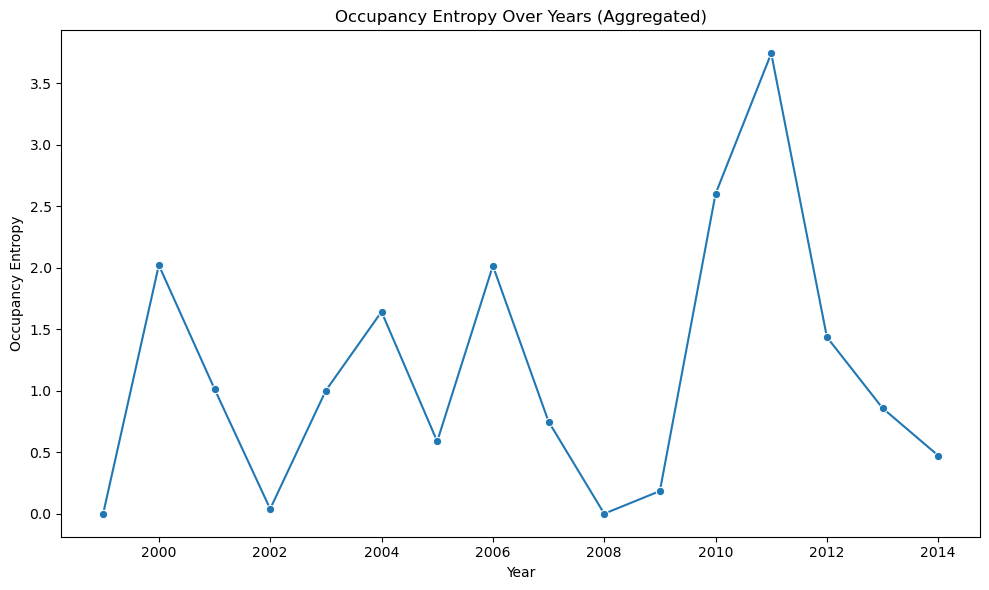

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_10867/2465777546.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')


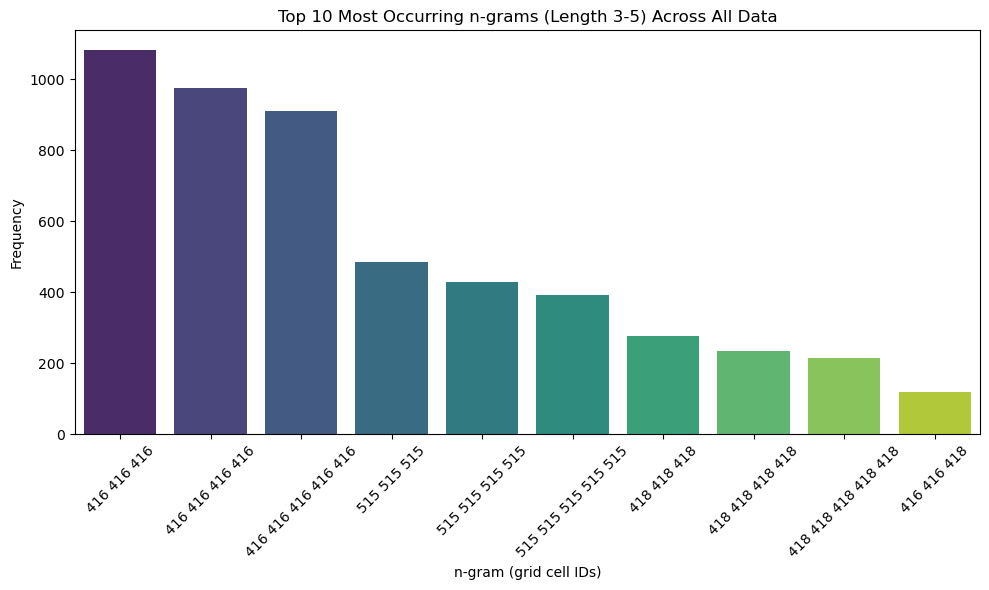


All plots produced. In the spatial maps, grid lines show the boundaries of 1.75°×1.75° fields.
In the network graphs, node colors indicate occupancy (darker colors mean higher visit frequency).


In [85]:
def main():
    df = pd.read_csv(FILE)
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    
    # Filter for species "Adelie Penguin".
    df_species = df[df['common_name'] == 'Chinstrap Penguin'].copy()
    if df_species.empty:
        print(f"No data found for species {SPECIES}.")
        return
    
    # Rasterize all data.
    df_species, grid_info = assign_grid_cells(df_species, resolution=FIXED_RESOLUTION)
    df_species['year'] = df_species['date_gmt'].dt.year
    
    # Plot spatial maps by year.
    plot_spatial_map_by_year(df_species, grid_info)
    
    # Plot enhanced network graphs by year.
    plot_networks_by_year(df_species, grid_info)
    
    # Plot aggregated network metrics over time.
    plot_network_metrics_over_time(df_species)
    
    # --- Motif Extraction using n-grams ---
    df_species = df_species.sort_values(by='date_gmt')
    cell_seq_all = df_species['cell_id'].tolist()
    ngrams_all = extract_ngrams(cell_seq_all, min_length=3, max_length=5)
    if ngrams_all:
        # For interpretability, recode each n-gram as a space-separated string.
        motif_patterns = [" ".join(map(str, ngram)) for ngram in ngrams_all]
        motif_counts = Counter(motif_patterns)
        top_motifs = motif_counts.most_common(10)
        patterns, freqs = zip(*top_motifs)
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')
        plt.title("Top 10 Most Occurring n-grams (Length 3-5) Across All Data")
        plt.xlabel("n-gram (grid cell IDs)")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No n-grams extracted.")
    
    print("\nAll plots produced. In the spatial maps, grid lines show the boundaries of 1.75°×1.75° fields.")
    print("In the network graphs, node colors indicate occupancy (darker colors mean higher visit frequency).")
    
if __name__ == '__main__':
    main()

## Gentoo Penguin

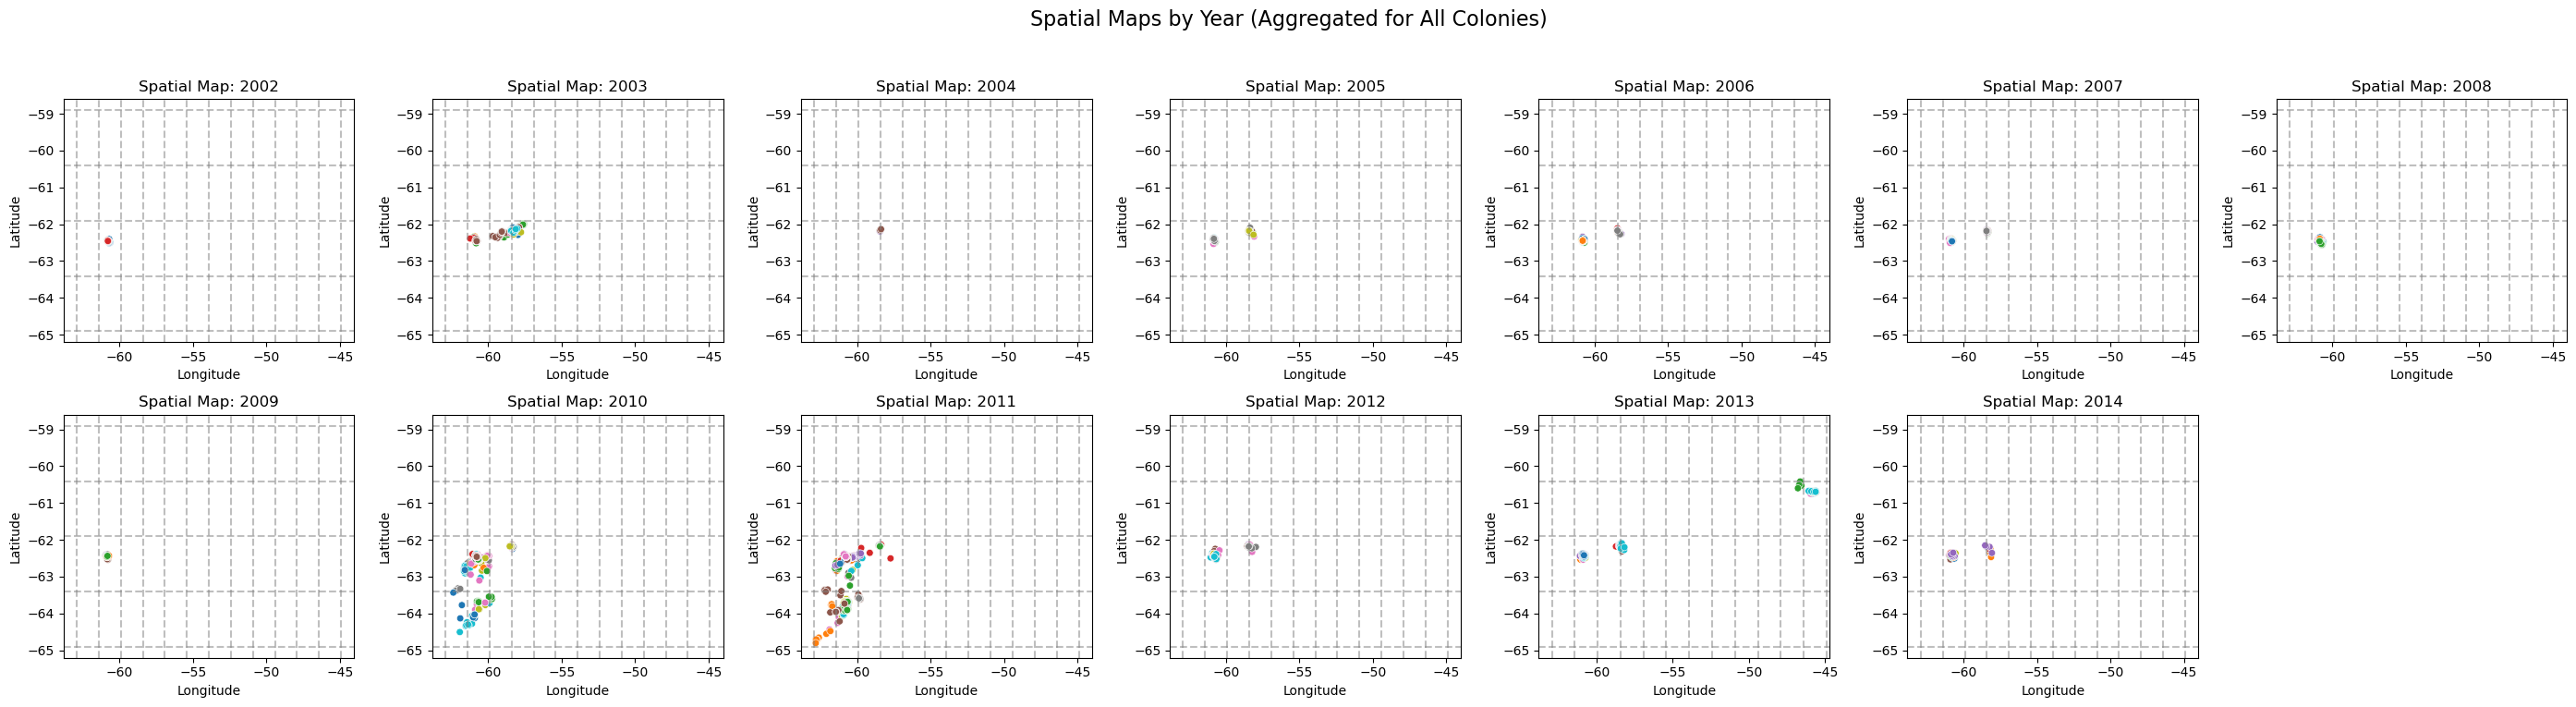

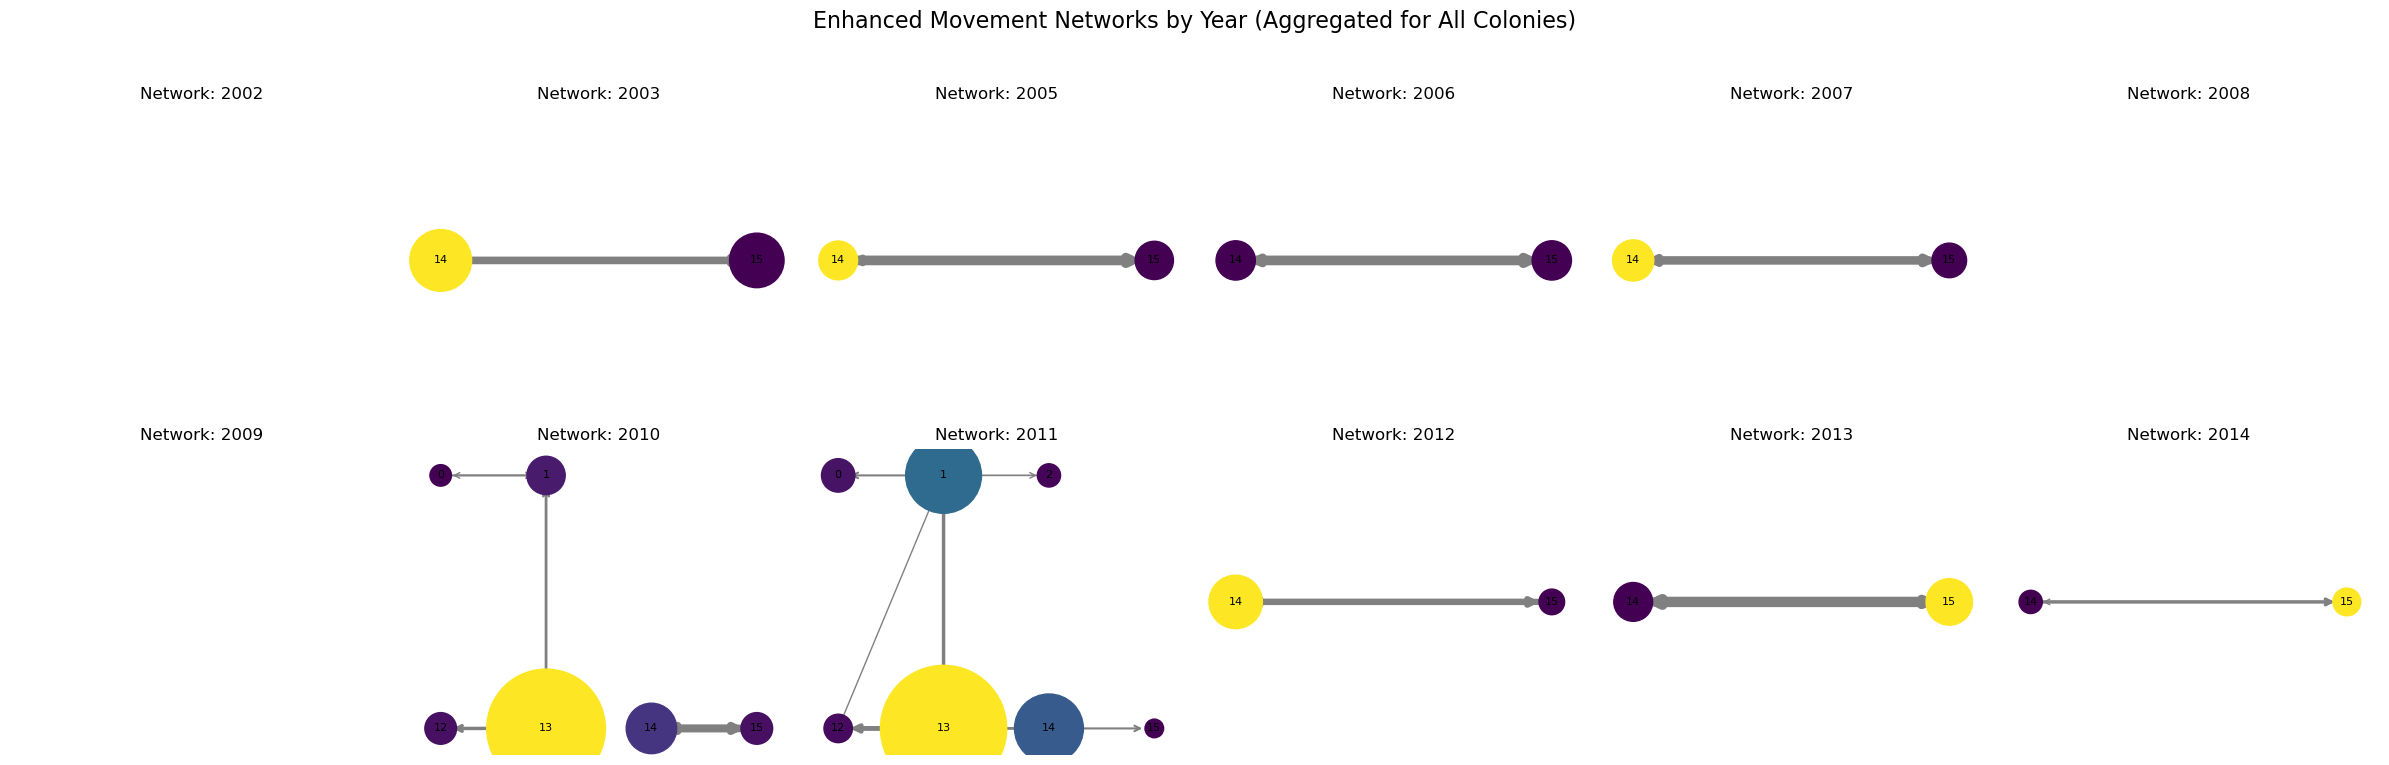

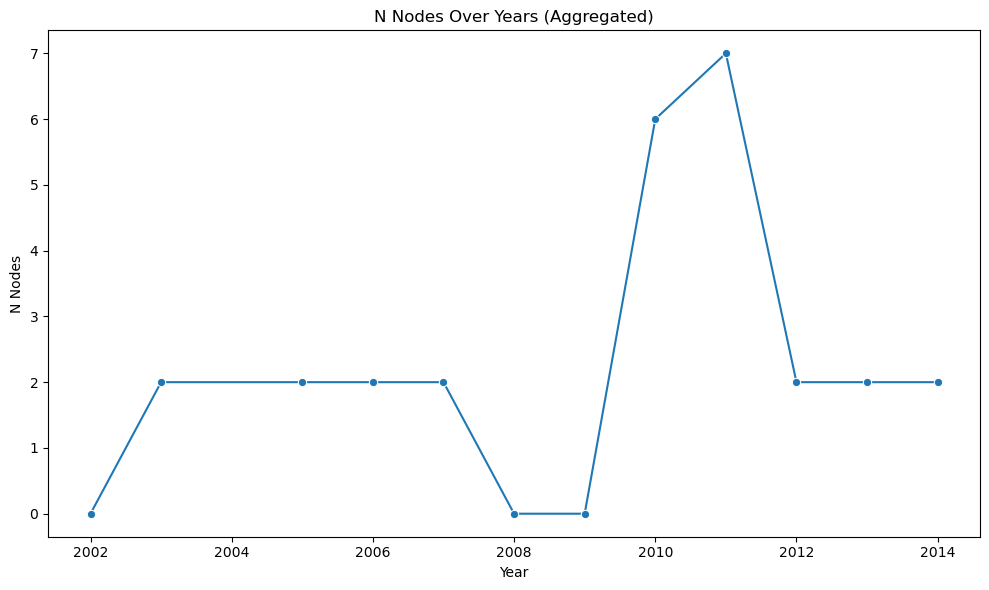

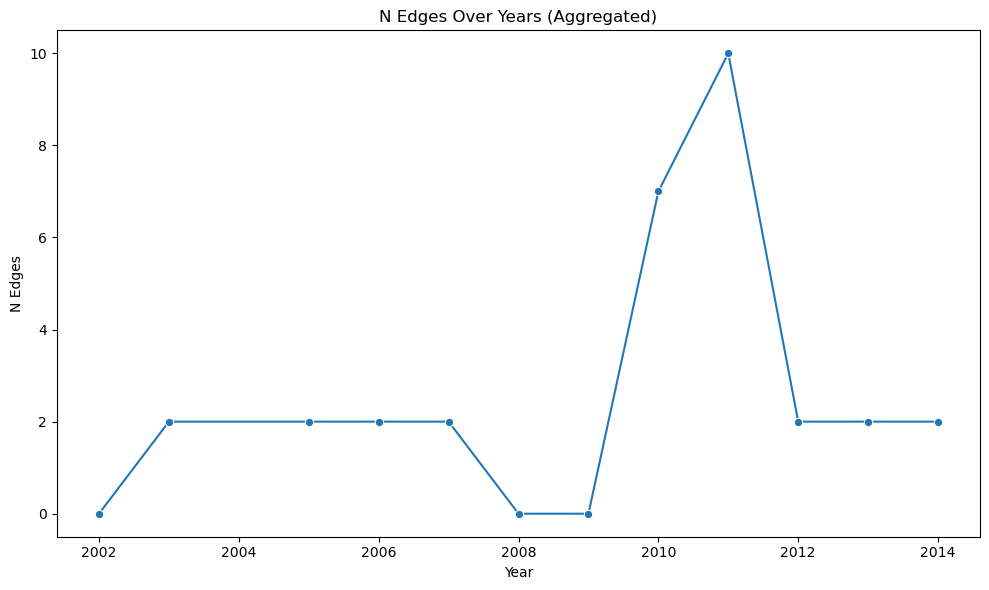

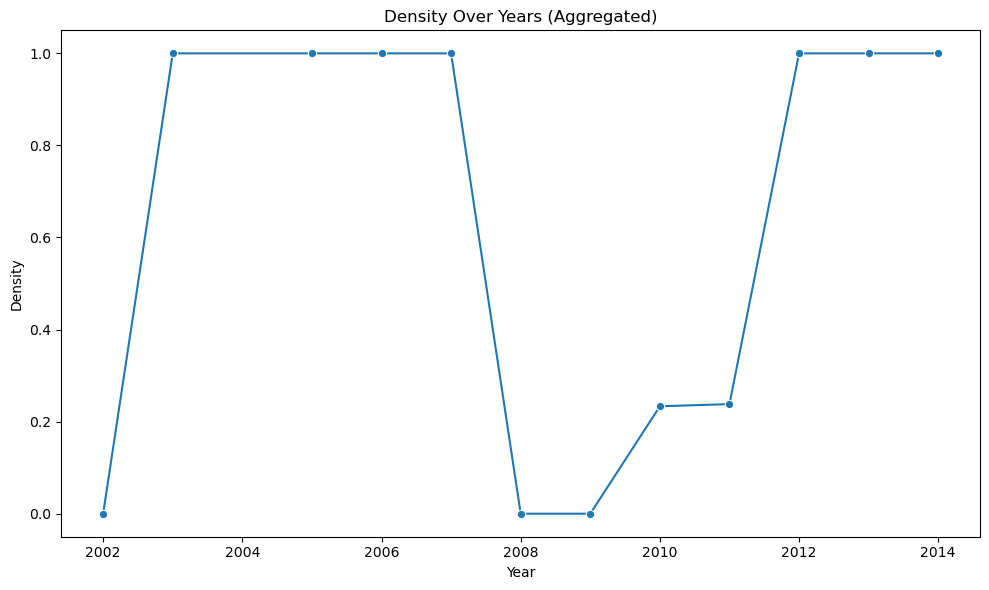

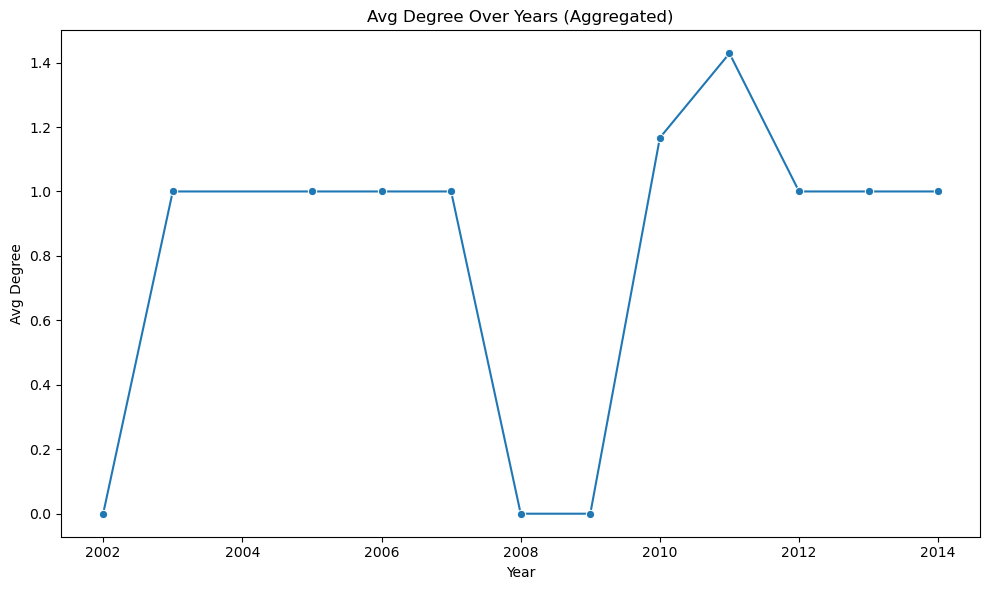

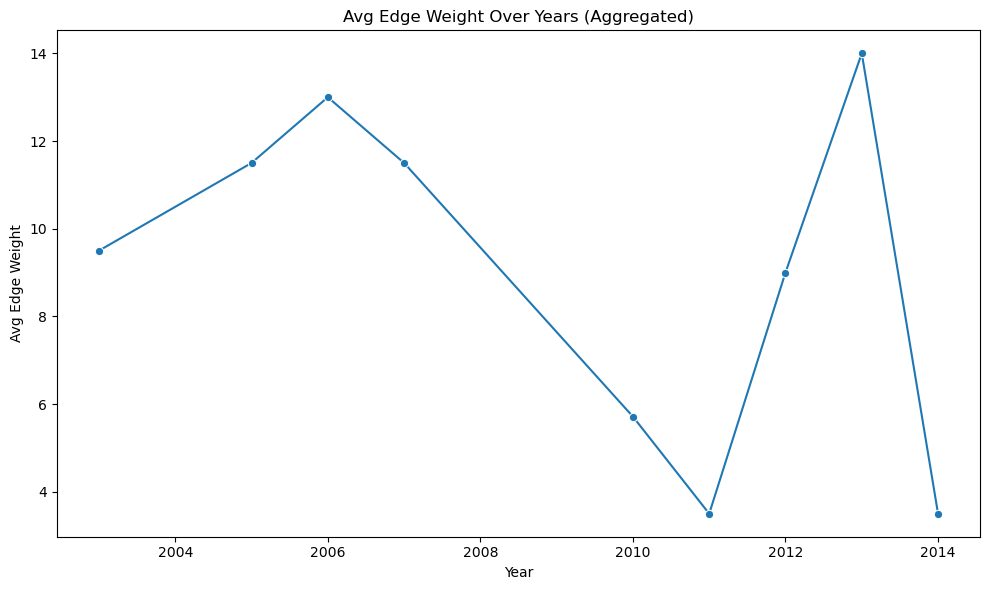

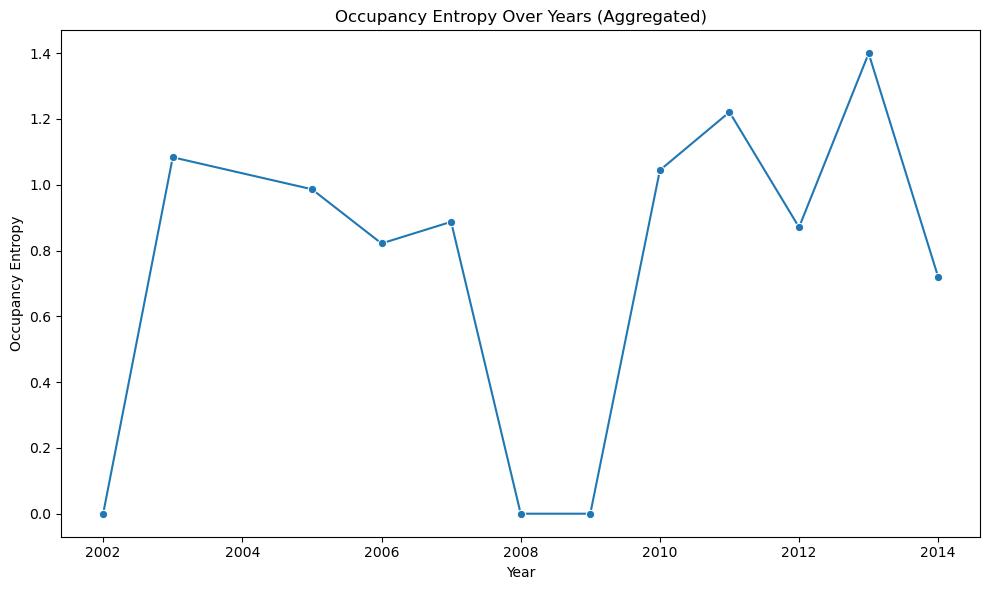

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_10867/1094331011.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')


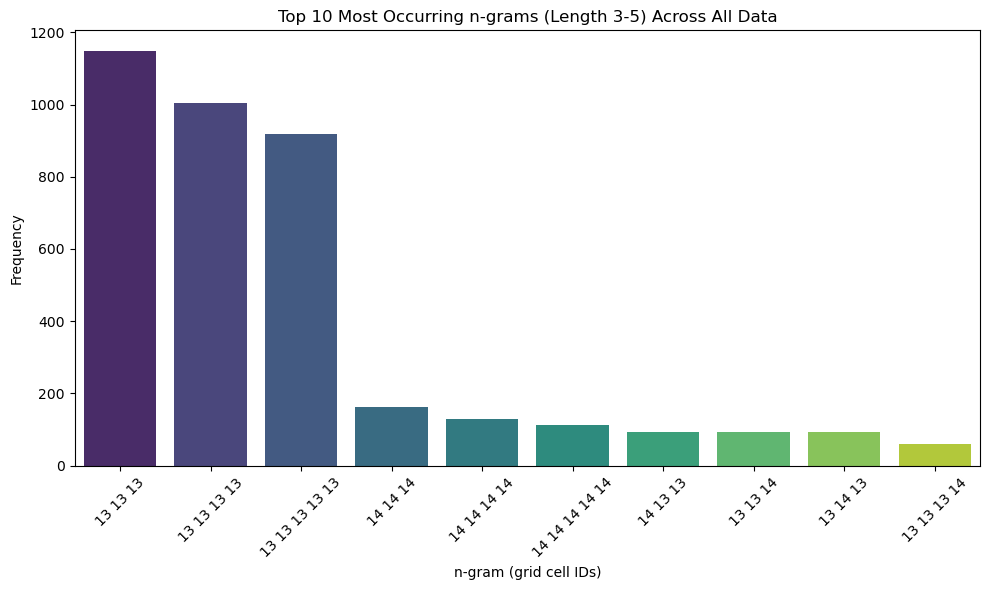


All plots produced. In the spatial maps, grid lines show the boundaries of 1.75°×1.75° fields.
In the network graphs, node colors indicate occupancy (darker colors mean higher visit frequency).


In [82]:
def main():
    df = pd.read_csv(FILE)
    df['date_gmt'] = pd.to_datetime(df['date_gmt'])
    
    # Filter for species "Adelie Penguin".
    df_species = df[df['common_name'] == 'Gentoo Penguin'].copy()
    if df_species.empty:
        print(f"No data found for species {SPECIES}.")
        return
    
    # Rasterize all data.
    df_species, grid_info = assign_grid_cells(df_species, resolution=FIXED_RESOLUTION)
    df_species['year'] = df_species['date_gmt'].dt.year
    
    # Plot spatial maps by year.
    plot_spatial_map_by_year(df_species, grid_info)
    
    # Plot enhanced network graphs by year.
    plot_networks_by_year(df_species, grid_info)
    
    # Plot aggregated network metrics over time.
    plot_network_metrics_over_time(df_species)
    
    # --- Motif Extraction using n-grams ---
    df_species = df_species.sort_values(by='date_gmt')
    cell_seq_all = df_species['cell_id'].tolist()
    ngrams_all = extract_ngrams(cell_seq_all, min_length=3, max_length=5)
    if ngrams_all:
        # For interpretability, recode each n-gram as a space-separated string.
        motif_patterns = [" ".join(map(str, ngram)) for ngram in ngrams_all]
        motif_counts = Counter(motif_patterns)
        top_motifs = motif_counts.most_common(10)
        patterns, freqs = zip(*top_motifs)
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(patterns), y=list(freqs), palette='viridis')
        plt.title("Top 10 Most Occurring n-grams (Length 3-5) Across All Data")
        plt.xlabel("n-gram (grid cell IDs)")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No n-grams extracted.")
    
    print("\nAll plots produced. In the spatial maps, grid lines show the boundaries of 1.75°×1.75° fields.")
    print("In the network graphs, node colors indicate occupancy (darker colors mean higher visit frequency).")
    
if __name__ == '__main__':
    main()